# CH10

## 10.2 온도 예측 문제

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-12-26 13:47:38--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.61.248, 52.217.40.246, 52.217.228.184, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.61.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  38.6MB/s    in 0.3s    

2023-12-26 13:47:38 (38.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


10-1 예나 날씨 데이터셋 조사하기

In [2]:
import os

In [3]:
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


10-2 데이터 파싱

In [4]:
import numpy as np

In [5]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]  # 두번째 열을 temperature 배열에 저장
    raw_data[i, :] = values[:]  # 온도 포함하여 모든 열을 'raw_data' 배열에 저장

10-3 전체 온도를 그래프로 그리기

In [6]:
from matplotlib import pyplot as plt

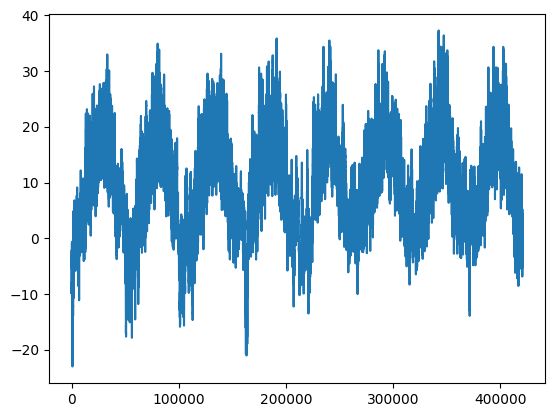

In [7]:
plt.plot(range(len(temperature)), temperature)
plt.show()

10-4 처음 10일간의 온도를 그래프로 그리기

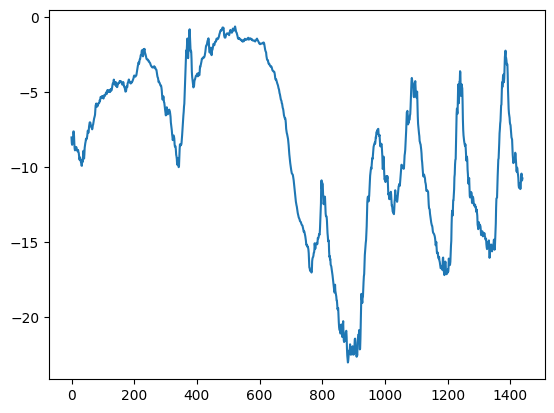

In [8]:
plt.plot(range(1440), temperature[:1440])
plt.show()

10-5 각 분할에 사용할 샘플 개수 계산하기

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 10.2.1 데이터 준비

10-6 데이터 정규화

In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

10-7 훈련, 검증, 테스트, 데이터셋 만들기

In [11]:
from tensorflow import keras

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

10-8 훈련 데이터셋의 배치 크기 확인하기

In [13]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


### 10.2.2 상식 수준의 기준점

10-9 상식 수준 모델의 MAE 계산하기

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]  # 온도 특성은 컬럼 인덱스 1 -> samples[:,-1,1]이 입력 시퀀스에 있는 마지막 온도 측정값, 정규화했기 때문에
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


### 10.2.3 기본적인 머신 러닝 모델 시도해보기

10-10 밀집 연결 모델 훈련하고 평가하기

In [15]:
from tensorflow.keras import layers

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",  # 콜백사용하여 최상의 모델을 저장
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")  # 최상의 모델을 다시 로드하고 테스트 데이터에서 평
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 51s 61ms/step - loss: 12.5543 - mae: 2.7315 - val_loss: 14.6723 - val_mae: 3.0524
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 9.0127 - mae: 2.3653 - val_loss: 10.2957 - val_mae: 2.5253
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 8.2713 - mae: 2.2673 - val_loss: 10.1155 - val_mae: 2.4991
Epoch 4/10
819/819 [==============================] - 51s 62ms/step - loss: 7.8336 - mae: 2.2052 - val_loss: 10.3880 - val_mae: 2.5229
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 7.5461 - mae: 2.1636 - val_loss: 11.2015 - val_mae: 2.6216
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 7.3327 - mae: 2.1324 - val_loss: 11.2081 - val_mae: 2.6230
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 7.1312 - mae: 2.1021 - val_loss: 10.6754 - val_mae: 2.5553
Epoch 8/10
819/819 [==============================] - 

10-11 결과 그래프 그리기

In [17]:
import matplotlib.pyplot as plt

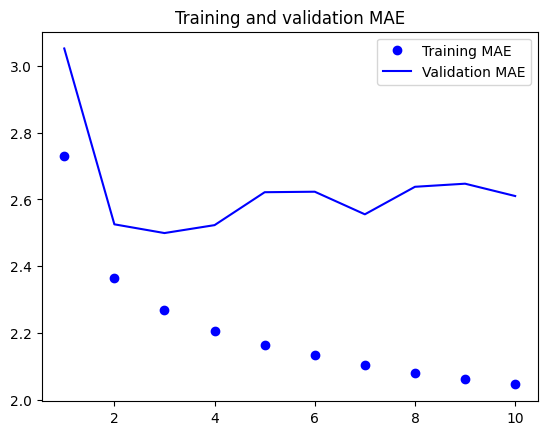

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 10.2.4 1D 합성곱 모델 시도해보기

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 74s 89ms/step - loss: 22.8577 - mae: 3.7102 - val_loss: 14.7922 - val_mae: 3.0476
Epoch 2/10
819/819 [==============================] - 78s 95ms/step - loss: 15.0447 - mae: 3.0844 - val_loss: 15.2166 - val_mae: 3.0604
Epoch 3/10
819/819 [==============================] - 73s 89ms/step - loss: 13.7015 - mae: 2.9345 - val_loss: 13.9350 - val_mae: 2.9654
Epoch 4/10
819/819 [==============================] - 76s 92ms/step - loss: 12.8604 - mae: 2.8398 - val_loss: 13.4715 - val_mae: 2.9002
Epoch 5/10
819/819 [==============================] - 78s 95ms/step - loss: 12.1387 - mae: 2.7536 - val_loss: 13.9951 - val_mae: 2.9694
Epoch 6/10
819/819 [==============================] - 75s 92ms/step - loss: 11.5883 - mae: 2.6908 - val_loss: 13.6463 - val_mae: 2.9235
Epoch 7/10
819/819 [==============================] - 75s 91ms/step - loss: 11.1639 - mae: 2.6432 - val_loss: 14.2591 - val_mae: 2.9832
Epoch 8/10
819/819 [============================

### 10.2.5 첫번째 순환 신경망

10-12 간단한 LSTM 기반 모델

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 122s 144ms/step - loss: 42.4491 - mae: 4.7613 - val_loss: 12.7392 - val_mae: 2.7068
Epoch 2/10
819/819 [==============================] - 118s 143ms/step - loss: 11.2479 - mae: 2.6013 - val_loss: 9.5235 - val_mae: 2.4058
Epoch 3/10
819/819 [==============================] - 117s 142ms/step - loss: 9.9460 - mae: 2.4548 - val_loss: 10.0290 - val_mae: 2.4544
Epoch 4/10
819/819 [==============================] - 118s 144ms/step - loss: 9.4378 - mae: 2.3907 - val_loss: 9.7086 - val_mae: 2.4224
Epoch 5/10
819/819 [==============================] - 116s 141ms/step - loss: 9.0634 - mae: 2.3408 - val_loss: 9.9863 - val_mae: 2.4649
Epoch 6/10
819/819 [==============================] - 99s 120ms/step - loss: 8.8056 - mae: 2.3054 - val_loss: 10.0568 - val_mae: 2.4613
Epoch 7/10
819/819 [==============================] - 99s 120ms/step - loss: 8.6344 - mae: 2.2818 - val_loss: 10.2428 - val_mae: 2.4973
Epoch 8/10
819/819 [========================

## 10.3 순환 신경망 이해하기

10-13 의사 코드로 표현한 RNN

In [ ]:
state_t = 0
for input_t in input_sequence:  # 시퀀스의 원소를 반복
  output_t = f(input_t, state_t)
  state_t = output_t  # 출력은 다음 반복을 위한 상태가

10-14 좀 더 자세한 의사코드로 표현한 RNN

In [ ]:
state_t = 0
for oinput_t in input_sequence:
  ouput_t = activation(dot(W, input_t) + dot(U, state_t) + b)
  state_t = output_t

10-15 넘파이로 구현한 간단한 RNN

In [21]:
import numpy as np

In [22]:
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### 10.3.1 케라스의 순환 층

10-16 어떤 길이의 시퀀스도 처리할 수 있는 RNN 층

In [23]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

10-17 마지막 출력 스텝만 반환하는 RNN층

In [24]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


10-18 전체 출력 시퀀스를 반환하는 RNN층

In [25]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


10-19 스태킹 RNN층

In [26]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

10-20, 10-21 LSTM의 구조 의사코드

In [ ]:
output_t = activation(c_t) * activation(dot(input_t, Wo) + dot(state_t, Uo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

c_t+1 = i_t * k_t + c_t * f_t

## 10.4 순환 신경망의 고급 사용법

10-22 드롭아웃 규제를 적용한 LSTM 모델 훈련하고 평가하기

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

10-23 드롭아웃 규제와 스태킹을 적용한 GRU 모델을 훈련하고 평가하기

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

10-24 양방향 LSTM 모델 훈련하고 평가하기

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)